<span style="font-size:1.5em;">[**reference**](https://wikidocs.net/22889)</span>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

from scipy.stats import truncnorm, norm, levene, ttest_ind

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, Zeros
from tensorflow.keras import backend as K
from tensorflow.math import sigmoid, tanh

In [2]:
n_samples = 5533
max_len = 20
vocab_size = 1234
embedding_dim = 300

hidden_states = 128

# Example 1: with embedding layer

In [276]:
rng = np.random.default_rng(42)
X = rng.integers(0,vocab_size, size=(n_samples, max_len))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len, ))
X_emb = model(X)

model.add(
            GRU(hidden_states,  return_sequences=True, return_state=False, input_shape= (max_len, embedding_dim), reset_after=False, use_bias=True,
               bias_initializer='glorot_normal')
         )
hidden_state = model(X)
gru = model.layers[1]

if `reset_after=True`, then `bias` of GRUCell has (2, 3*`gru.units`) shape.

In [277]:
ki = gru.cell.kernel[:, :hidden_states]
kf = gru.cell.kernel[:, hidden_states:2*hidden_states]
kc = gru.cell.kernel[:, 2*hidden_states:]


ri = gru.cell.recurrent_kernel[:, :hidden_states]
rf = gru.cell.recurrent_kernel[:, hidden_states:2*hidden_states]
rc = gru.cell.recurrent_kernel[:, 2*hidden_states:]

if gru.reset_after:
    bi = gru.cell.bias[:, :hidden_states]
    bf = gru.cell.bias[:, hidden_states:2*hidden_states]
    bc = gru.cell.bias[:, 2*hidden_states:]
else:
    bi = gru.cell.bias[:hidden_states]
    bf = gru.cell.bias[hidden_states:2*hidden_states]
    bc = gru.cell.bias[2*hidden_states:]

In [278]:
# X_emb_nor = tf.linalg.normalize(X_emb, axis=2, )[0]

In [279]:
for t in range(max_len):
    if t>0: htt = ht # hidden_state[:,t-1,:]
    else: htt = tf.zeros((n_samples, hidden_states))
    X_tf_ = X_emb[:,t,:]
    
    if gru.reset_after:
        zt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, ki), bi[0]) + K.bias_add(tf.matmul(htt, ri), bi[1]))
        rt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, kf), bf[0]) + K.bias_add(tf.matmul(htt, rf), bf[1]))

        gt = gru.activation(K.bias_add(tf.matmul(X_tf_, kc), bc[0]) + rt*(K.bias_add(tf.matmul(htt, rc), bc[1])) )
    else:
        zt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, ki), bi) + (tf.matmul(htt, ri)) )
        rt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, kf), bf) + (tf.matmul(htt, rf)) )

        gt = gru.activation(K.bias_add(tf.matmul(X_tf_, kc), bc) + (tf.matmul(rt*htt, rc)) )
    ht = (1-zt)*gt + zt*htt
    
    print('t={}'.format(str(t).zfill(2)), end=', ')
    print('validation - calculating hidden state:', np.alltrue(hidden_state[:,t,:]== ht, ), abs(ht- hidden_state[:,t,:]).numpy().max() )

t=00, validation - calculating hidden state: True 0.0
t=01, validation - calculating hidden state: True 0.0
t=02, validation - calculating hidden state: True 0.0
t=03, validation - calculating hidden state: True 0.0
t=04, validation - calculating hidden state: True 0.0
t=05, validation - calculating hidden state: True 0.0
t=06, validation - calculating hidden state: True 0.0
t=07, validation - calculating hidden state: True 0.0
t=08, validation - calculating hidden state: True 0.0
t=09, validation - calculating hidden state: True 0.0
t=10, validation - calculating hidden state: True 0.0
t=11, validation - calculating hidden state: True 0.0
t=12, validation - calculating hidden state: True 0.0
t=13, validation - calculating hidden state: True 0.0
t=14, validation - calculating hidden state: True 0.0
t=15, validation - calculating hidden state: True 0.0
t=16, validation - calculating hidden state: True 0.0
t=17, validation - calculating hidden state: True 0.0
t=18, validation - calculati

# Example 2: with normalizing dataset

In [270]:
rng = np.random.default_rng(42)
X = rng.normal(size=(n_samples, max_len, embedding_dim))
# X_tf = tf.linalg.normalize(X, axis=2, )[0]
# X = np.array([Normalizer().fit_transform(X[s]) for s in range(n_samples) ])
X_tf = tf.cast(X, dtype=tf.float32)

gru = GRU(hidden_states,  return_sequences=True, return_state=True, input_shape= (max_len, embedding_dim), reset_after=False,
         bias_initializer='uniform')
hidden_state, last_state, = gru(X)

In [271]:
hidden_state.shape

TensorShape([5533, 20, 128])

In [272]:
np.alltrue(hidden_state[:,-1,:]==last_state)

True

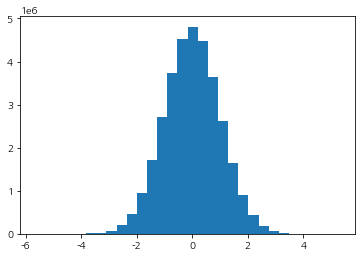

In [273]:
plt.hist(X.flatten(), bins=30)
plt.show()

In [274]:
ki = gru.cell.kernel[:, :hidden_states]
kf = gru.cell.kernel[:, hidden_states:2*hidden_states]
kc = gru.cell.kernel[:, 2*hidden_states:]


ri = gru.cell.recurrent_kernel[:, :hidden_states]
rf = gru.cell.recurrent_kernel[:, hidden_states:2*hidden_states]
rc = gru.cell.recurrent_kernel[:, 2*hidden_states:]

if gru.reset_after:
    bi = gru.cell.bias[:, :hidden_states]
    bf = gru.cell.bias[:, hidden_states:2*hidden_states]
    bc = gru.cell.bias[:, 2*hidden_states:]
else:
    bi = gru.cell.bias[:hidden_states]
    bf = gru.cell.bias[hidden_states:2*hidden_states]
    bc = gru.cell.bias[2*hidden_states:]

In [275]:
for t in range(max_len):
    if t>0: htt = ht # hidden_state[:,t-1,:]
    else: htt = tf.zeros((n_samples, hidden_states))
    X_tf_ = X_tf[:,t,:]

    if gru.reset_after:
        zt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, ki), bi[0]) + K.bias_add(tf.matmul(htt, ri), bi[1]))
        rt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, kf), bf[0]) + K.bias_add(tf.matmul(htt, rf), bf[1]))

        gt = gru.activation(K.bias_add(tf.matmul(X_tf_, kc), bc[0]) + rt*(K.bias_add(tf.matmul(htt, rc), bc[1])) )
    else:
        zt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, ki), bi) + (tf.matmul(htt, ri)) )
        rt = gru.recurrent_activation(K.bias_add(tf.matmul(X_tf_, kf), bf) + (tf.matmul(htt, rf)) )

        gt = gru.activation(K.bias_add(tf.matmul(X_tf_, kc), bc) + (tf.matmul(rt*htt, rc)) )
    ht = (1-zt)*gt + zt*htt
    
    print('t={}'.format(str(t).zfill(2)), end=', ')
    print('validation - calculating hidden state:', np.alltrue(hidden_state[:,t,:] == ht, ), abs(ht- hidden_state[:,t,:]).numpy().max())


t=00, validation - calculating hidden state: True 0.0
t=01, validation - calculating hidden state: True 0.0
t=02, validation - calculating hidden state: True 0.0
t=03, validation - calculating hidden state: True 0.0
t=04, validation - calculating hidden state: True 0.0
t=05, validation - calculating hidden state: True 0.0
t=06, validation - calculating hidden state: True 0.0
t=07, validation - calculating hidden state: True 0.0
t=08, validation - calculating hidden state: True 0.0
t=09, validation - calculating hidden state: True 0.0
t=10, validation - calculating hidden state: True 0.0
t=11, validation - calculating hidden state: True 0.0
t=12, validation - calculating hidden state: True 0.0
t=13, validation - calculating hidden state: True 0.0
t=14, validation - calculating hidden state: True 0.0
t=15, validation - calculating hidden state: True 0.0
t=16, validation - calculating hidden state: True 0.0
t=17, validation - calculating hidden state: True 0.0
t=18, validation - calculati